<a href="https://colab.research.google.com/github/s-thandri/labelflipping/blob/main/german_income/german_credit_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
warnings.filterwarnings('ignore')


In [2]:
#This function is being used to calculate the statistical parity of the data set
#test_data: The original data frame containing the test data
#predictors: List of the all the column names AKA IV's
#prediction_df: Contains the predicitons made by the DT model
#sensitive_attr: Name of the sensitive attr
#sensitive_attr_cutoff: Cut off value for sensitive attr
#concat_col: Name of column I am creating new dataframe on
def s_parity(test_data, predictors, prediction_df, sensitive_attr, sensitive_attr_cutoff, concat_col):
    #Creating a new DF that contains all the datapoints from the test data and the predictions made from LR model
    #Concat_col: credit_risk_12
    test_demo_df = pd.DataFrame(test_data, columns = predictors)
    predicted_df = pd.DataFrame(prediction_df, columns = [concat_col])
    concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

    #Get the two groups of people totals
    total_unpriv = (len(concat_df[concat_df[sensitive_attr]<sensitive_attr_cutoff]))
    total_priv = (len(concat_df[concat_df[sensitive_attr]>=sensitive_attr_cutoff]))

    #Number of people accepted
    total_credit_unpriv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] < sensitive_attr_cutoff)])
    total_credit_priv = len(concat_df[(concat_df[concat_col] == 1) & (concat_df[sensitive_attr] >= sensitive_attr_cutoff)])

    #Percentage of approved people
    p_unpriv = total_credit_unpriv/total_unpriv
    p_priv = total_credit_priv/total_priv


    #Calculate the parity
    parity = p_priv - p_unpriv


    return parity

In [3]:
#Make changes to make more efficient
#Function used to run the DT model
#train_dataset: Training dataset to train the model
#independent_var: Column names
#dependent_var: Prediction column name
#concat_col: Name of column creating new DF on
def decision_tree(train_dataset, independent_var, dependent_var, concat_col):
        #Split the data up into train and test values and then run the DT model
        #These steps aren't neccessary to consistenly do over and over again
        x = train_dataset[independent_var].values
        y = train_dataset[dependent_var].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=210)
        clf = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3, min_samples_leaf=5)
        log = clf.fit(x_train,y_train)
        prediction = log.predict(x_test)

        #Printing the Overall accuracy of the model after one run
        #F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
        #file.write(f'\nAccuracy of the model on Testing Sample Data: {F1_Score}')

        #Prints out the average across all ten run throughs
        #Accuracy_Values=cross_val_score(log, x , y, cv=10, scoring='f1_weighted')

        accuracy = accuracy_score(y_test,prediction)*100

        #After running the model I return a df with the datapoints and the labels
        test_demo_df = pd.DataFrame(x_test, columns = independent_var)
        #Concat_col: credit_risk_12
        predicted_df = pd.DataFrame(prediction, columns = [concat_col])

        return accuracy, test_demo_df, predicted_df

In [4]:
#Defining the columns and creating the Dataframe with all 1000 datapoints
columns = ["checking_account_status", "duration", "credit_history", "purpose", "credit_amount", "savings_account_status", "employment_status", "installment_rate", "personal_status", "other_debtors", "residence_since", "property", "age", "other_installment_plans", "housing", "existing_credits", "job", "num_dependents", "telephone", "foreign_worker", "credit_risk"]
german_df = pd.read_table('german.data', header = None, delim_whitespace=True, names = columns)

In [5]:
#Encode all the non-numeric columns with dummies
encoded_data=pd.get_dummies(german_df,columns=['checking_account_status','credit_history','savings_account_status','employment_status','personal_status','other_debtors','property','other_installment_plans','housing','job','telephone','foreign_worker','purpose'], drop_first=True)

In [6]:
# Preprocess labels (assuming labels are 1 for good and 2 for bad)
#encoded_data['credit_risk'] = encoded_data['credit_risk'].apply(lambda x: 0 if x == 2 else 1)

In [7]:
#Initialize all the different columns including predictors and target variable
encoded_data.columns
target_var = 'credit_risk'
predictors = ['duration', 'credit_amount', 'installment_rate',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'checking_account_status_A12',
       'checking_account_status_A13', 'checking_account_status_A14',
       'credit_history_A31', 'credit_history_A32', 'credit_history_A33',
       'credit_history_A34', 'savings_account_status_A62',
       'savings_account_status_A63', 'savings_account_status_A64',
       'savings_account_status_A65', 'employment_status_A72',
       'employment_status_A73', 'employment_status_A74',
       'employment_status_A75', 'personal_status_A92', 'personal_status_A93',
       'personal_status_A94', 'other_debtors_A102', 'other_debtors_A103',
       'property_A122', 'property_A123', 'property_A124',
       'other_installment_plans_A142', 'other_installment_plans_A143',
       'housing_A152', 'housing_A153', 'job_A172', 'job_A173', 'job_A174',
       'telephone_A192', 'foreign_worker_A202']


In [8]:
#Setting the columns to each part of the decision tree
#x conatins the IV's
#y contains the DV
x = encoded_data[predictors].values
y = encoded_data[target_var].values

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=210)
#X-train is all the data points for training
#y_train contains the labels for each of the training data points
#x_test contains all the testing data points
#y_test contains the ground truth for each of the test data points

In [10]:
#Run the DT classifier
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_leaf=5)
dt = clf.fit(x_train,y_train)
prediction = dt.predict(x_test)
prediction_prob = dt.predict_proba(x_test)

In [11]:
#Break the test dataframe into different groups
#Unprotected group is everyone <45
#Complement group is everyone >= 45
test_demo_df = pd.DataFrame(x_test, columns = predictors)
predicted_df = pd.DataFrame(prediction, columns = ['credit_risk_12'])
concat_df = pd.concat([test_demo_df,predicted_df], axis=1)

#Get the two groups of people totals
total_unpriv = (len(concat_df[concat_df['age']<45]))
total_priv = (len(concat_df[concat_df['age']>=45]))

#Number of people accepted
total_credit_unpriv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] < 45)])
total_credit_priv = len(concat_df[(concat_df['credit_risk_12'] == 1) & (concat_df['age'] >= 45)])

#Percentage of approved people
p_unpriv = total_credit_unpriv/total_unpriv
p_priv = total_credit_priv/total_priv

statistical_parity = p_priv - p_unpriv
print(f'Statistical Parity: {statistical_parity:.5f}')


Statistical Parity: 0.10066


In [12]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(x_train, columns = predictors)
train_outcome_df = pd.DataFrame(y_train, columns = ['credit_risk'])
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [13]:
# Obtain predicted probabilities on the training data
predicted_probabilities = dt.predict_proba(x_train)

In [14]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 1 (which is good), second value is 2(which is bad)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index, value in enumerate(predicted_probabilities):
  #Calculate p1 and p2
  p1=predicted_probabilities[index,0]
  p2=predicted_probabilities[index,1]
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2)
  entropy_calc2 = p2 * math.log(p2,2)
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)


In [15]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)

In [16]:
train_full_df['credit_risk'] = train_full_df['credit_risk'].astype('int')

In [17]:
#Convert each of the tuples into lists
ranked_indices_list = list(sorted_index_list)
ranked_entropy_list = list(sorted_ent_list)

#Get the top 500 points in the list
top_index_points = ranked_indices_list[:500]
top_entropy_list = ranked_entropy_list[:500]

In [18]:
#After ranking and getting the tope 500 points I flip them based on where they are in the list

#Different lists to hold each of the values
ranked_parity = [statistical_parity]
ranked_acc = []
ranked_flip = []

row_num = 0

#Go through the training dataset and flip the points based on their entropy levels
for row in range(len(top_index_points)):
  row_num = ranked_indices_list[row]

  if train_full_df.at[row_num,'credit_risk'] == 1:
    train_full_df.at[row_num,'credit_risk'] = 2
    accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
    ranked_parity.append(parity)

  elif train_full_df.at[row_num, 'credit_risk'] == 2:
    train_full_df.at[row_num,'credit_risk'] = 1
    accuracy,test_datapoints, test_prediction = decision_tree(train_full_df, predictors, target_var, 'credit_risk_12')

    ranked_flip.append(row_num)
    ranked_acc.append(accuracy)

    parity = s_parity(test_datapoints, predictors, test_prediction, 'age', 45, 'credit_risk_12')
    ranked_parity.append(parity)


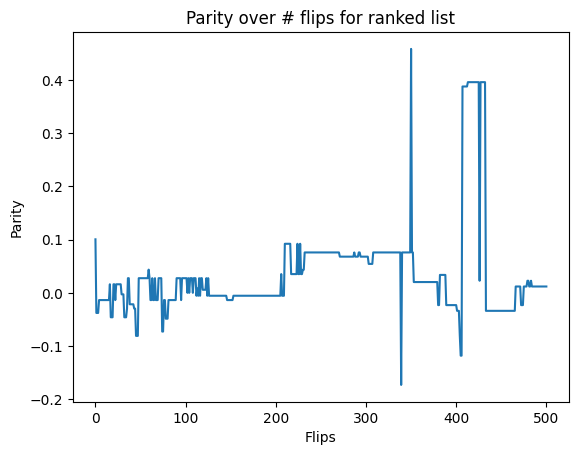

In [ ]:
#Plot of the information in the order of the flips of parity
x=range(len(ranked_parity))

#Plot the data
plt.plot(x,ranked_parity)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Parity over # flips for ranked list')

#Show the plot
plt.show()

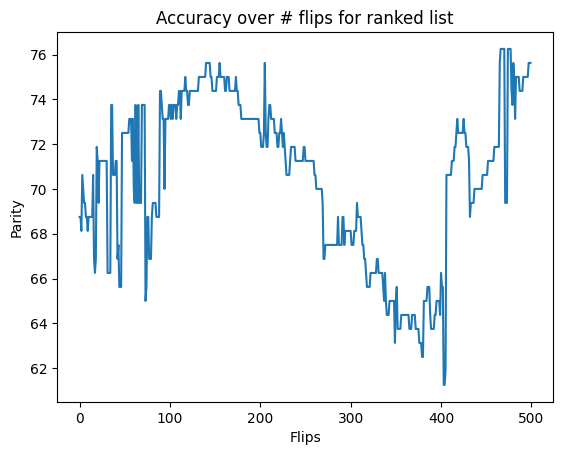

In [ ]:
#Plot of the information in the order of the flips of parity
x=range(len(ranked_acc))

#Plot the data
plt.plot(x,ranked_acc)

#Add the labels
plt.xlabel('Flips')
plt.ylabel('Parity')
plt.title('Accuracy over # flips for ranked list')

#Show the plot
plt.show()

In [ ]:
#Show the list of the flipped values in order to double check and make sure that the change is correct
print(ranked_parity)
print(ranked_acc)

[0.10066305003013865, -0.037574159525379014, -0.037574159525379014, -0.037574159525379014, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, -0.013403647549989017, 0.016260162601625994, -0.045704240826191955, -0.045704240826191955, -0.045704240826191955, 0.016260162601625994, 0.016260162601625994, -0.013403647549989017, 0.016260162601625994, 0.016260162601625994, 0.016260162601625994, 0.016260162601625994, 0.016260162601625994, 0.016260162601625994, -0.002636783124587927, -0.002636783124587927, -0.002636783124587927, -0.045704240826191955, -0.045704240826191955, -0.045704240826191955, -0.02944407822456596, 0.02768622280817401, 0.02768622280817401, -0.02131399692375302, -0.02131399692375302, -0.02131399692375302, -0.02131399692375302, -0.02131399692375302, -0.02944407822456596, -0.029444